# 1-2,图片数据建模流程范例

一，准备数据

cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile。

训练集有airplane和automobile图片各5000张，测试集有airplane和automobile图片各1000张。

cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。

我们准备的Cifar2数据集的文件结构如下所示。


在tensorflow中准备图片数据的常用方案有两种，第一种是使用tf.keras中的ImageDataGenerator工具构建图片数据生成器。

第二种是使用tf.data.Dataset搭配tf.image中的一些图片处理方法构建数据管道。

第一种方法更为简单，其使用范例可以参考以下文章。

《Keras图像数据预处理范例——Cifar2图片分类》

第二种方法是TensorFlow的原生方法，更加灵活，使用得当的话也可以获得更好的性能。

我们此处介绍第二种方法。

In [1]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)

In [3]:
#使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

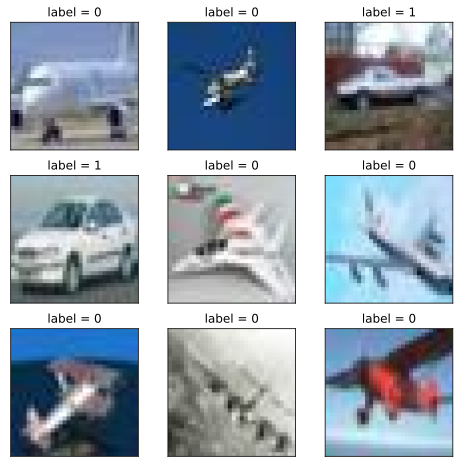

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [10]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)


## 二，定义模型

使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用函数式API构建模型。

In [15]:
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

## 三，训练模型

训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

In [16]:
import datetime
import os

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)


Epoch 1/10
100/100 [==============================] - 4s 39ms/step - loss: 0.4396 - accuracy: 0.7894 - val_loss: 0.3210 - val_accuracy: 0.8610
Epoch 2/10
100/100 [==============================] - 4s 38ms/step - loss: 0.3283 - accuracy: 0.8578 - val_loss: 0.2900 - val_accuracy: 0.8725
Epoch 3/10
100/100 [==============================] - 4s 38ms/step - loss: 0.2749 - accuracy: 0.8842 - val_loss: 0.2516 - val_accuracy: 0.8920
Epoch 4/10
100/100 [==============================] - 4s 36ms/step - loss: 0.2293 - accuracy: 0.9058 - val_loss: 0.1997 - val_accuracy: 0.9170
Epoch 5/10
100/100 [==============================] - 4s 37ms/step - loss: 0.1907 - accuracy: 0.9259 - val_loss: 0.1844 - val_accuracy: 0.9225
Epoch 6/10
100/100 [==============================] - 4s 36ms/step - loss: 0.1661 - accuracy: 0.9369 - val_loss: 0.1762 - val_accuracy: 0.9330
Epoch 7/10
100/100 [==============================] - 4s 38ms/step - loss: 0.1443 - accuracy: 0.9434 - val_loss: 0.1705 - val_accuracy: 0.9315

# 四，评估模型

In [17]:
%load_ext tensorboard
#%tensorboard --logdir ./data/keras_model

In [18]:
from tensorboard import notebook
notebook.list() 

No known TensorBoard instances running.


In [22]:
#在tensorboard中查看模型
notebook.start("--logdir ./data/keras_model")

Reusing TensorBoard on port 6006 (pid 3848), started 0:02:35 ago. (Use '!kill 3848' to kill it.)

In [23]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.439606,0.7894,0.320991,0.8610
2,0.328287,0.8578,0.290015,0.8725
3,0.274942,0.8842,0.251643,0.8920
4,0.229272,0.9058,0.199707,0.9170
5,0.190653,0.9259,0.184442,0.9225
6,0.166069,0.9369,0.176233,0.9330
7,0.144282,0.9434,0.170541,0.9315
8,0.132637,0.9481,0.153710,0.9390
9,0.113944,0.9558,0.159247,0.9365


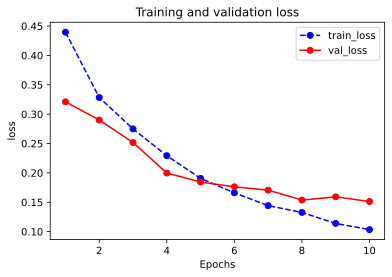

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history,"loss")

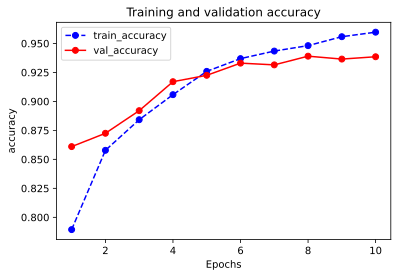

In [25]:
plot_metric(history,"accuracy")

In [26]:
#可以使用evaluate对数据进行评估
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 0s 11ms/step - loss: 0.1512 - accuracy: 0.9385
0.15123675763607025 0.9384999871253967


## 五，使用模型
可以使用model.predict(ds_test)进行预测。

也可以使用model.predict_on_batch(x_test)对一个批量进行预测。

In [27]:
model.predict(ds_test)

array([[9.75673556e-01],
       [7.17154145e-03],
       [2.05546618e-04],
       ...,
       [9.95656610e-01],
       [9.99882221e-01],
       [1.21945166e-04]], dtype=float32)

In [36]:
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

[[9.9996960e-01]
 [9.2571092e-01]
 [4.9945927e-05]
 [1.5011430e-04]
 [9.9999571e-01]
 [9.9425173e-01]
 [9.9946856e-01]
 [9.8336470e-01]
 [9.3186754e-01]
 [3.3628941e-04]
 [5.8584809e-03]
 [9.9971867e-01]
 [4.7191679e-03]
 [4.4955015e-03]
 [1.6992328e-06]
 [8.1928338e-06]
 [1.9442201e-02]
 [3.8454133e-01]
 [8.2786083e-03]
 [9.8958695e-01]]


## 六，保存模型
推荐使用TensorFlow原生方式保存模型。

In [37]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")

In [ ]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(ds_test)